# Import


In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


# LOAD DATA 

## Labélisation des données

In [2]:
df = pd.read_csv('datasetiot.csv')
# keep 100 000 first rows
df = df.iloc[:100000]
# add columns empty columns to the dataframe this will be used to store the labels
df['label'] = np.nan
df['label'] = df['label'].astype('category')
#set category types
df['label'].cat.set_categories(['Normal', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)

# line 0 to 5150 is FTP traffic
df.loc[0:5150, 'label'] = 'Normal'
# line 5151 to 18600 is SSH traffic
df.loc[5151:18600, 'label'] = 'Normal'
# line 18601 to 28000 is FTP + SSH traffic
df.loc[18601:28000, 'label'] = 'Normal'
# line 28000 to 40100 is Keylogger traffic
df.loc[28000:40100, 'label'] = 'Keylogger'
# line 40101 to 46500 is FTP + SSH 
df.loc[40101:46500, 'label'] = 'Normal'
# line 46501 to 54100 is Reverse Shell
df.loc[46501:54100, 'label'] = 'Reverse Shell'
# line 54101 to 57150 is FTP + SSH
df.loc[54101:57150, 'label'] = 'Normal'
# the rest is syn flood
df.loc[57151:, 'label'] = 'SYN Flood'
# merge label SSH and FTP + SSH and FTP as "Normal"



C:\Users\enzoh\AppData\Local\Temp\ipykernel_32644\1072877512.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['label'].cat.set_categories(['Normal', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)


## Quelques visualisations

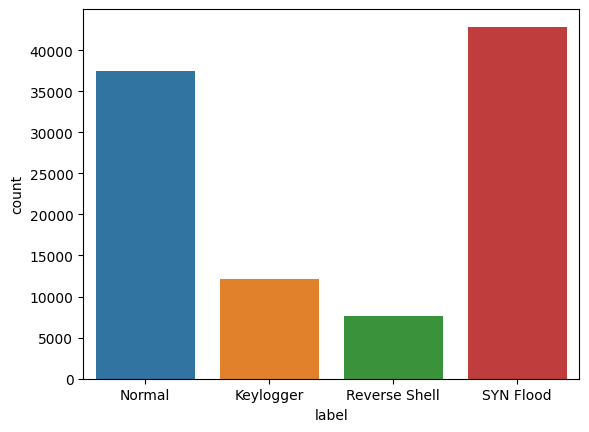

In [3]:
# plot diffrent features
# plot the distribution of the label
sns.countplot(x='label', data=df)
plt.show()
    

In [ ]:
# print all features
print(df.columns)

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'label'],
      dtype='object')


## Preprocessing


In [4]:
# preprocess the data
# drop the columns that are not needed "No" , "Time"
df = df.drop(['No.', 'Time'], axis=1)


In [5]:
df.head()

,Source,Destination,Protocol,Length,Info,label
0,192.168.174.1,239.255.255.250,SSDP,166,M-SEARCH * HTTP/1.1,Normal
1,192.168.174.1,239.255.255.250,SSDP,171,M-SEARCH * HTTP/1.1,Normal
2,172.16.0.1,239.255.255.250,SSDP,166,M-SEARCH * HTTP/1.1,Normal
3,172.16.0.1,239.255.255.250,SSDP,171,M-SEARCH * HTTP/1.1,Normal
4,192.168.174.1,239.255.255.250,SSDP,166,M-SEARCH * HTTP/1.1,Normal


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

# convert categorical data to numerical data
df['Protocol'] = df['Protocol'].astype('category')
df['Protocol'] = df['Protocol'].cat.codes
df['Source'] = df['Source'].astype('category')
df['Source'] = df['Source'].cat.codes
df['Destination'] = df['Destination'].astype('category')
df['Destination'] = df['Destination'].cat.codes
df['Info'] = df['Info'].astype('category')
df['Info'] = df['Info'].cat.codes
df.head()



,Source,Destination,Protocol,Length,Info,label
0,10155,11194,13,166,76629,1
1,10155,11194,13,171,76629,1
2,8070,11194,13,166,76629,1
3,8070,11194,13,171,76629,1
4,10155,11194,13,166,76629,1


In [7]:
# print all values of the label
print(df['label'].unique())
# print count of each label
print(df['label'].value_counts())

[1 0 2 3]
3    42849
1    37450
0    12101
2     7600
Name: label, dtype: int64


6

## Création des données d'entrainement et de test

In [35]:
import pandas as pd
import numpy as np

def format_data_time_step(data, time_step):
    """
    Format time-series data into a format suitable for training a recurrent neural network.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the time-series data. The DataFrame should contain a 'label' column
        and one or more feature columns.

    time_step : int
        The number of time steps (i.e., rows) to include in each sample.

    Returns
    -------
    tuple
        A tuple containing the following six elements in the order given:

        train_data : numpy.ndarray
            An array of shape (n_samples_train, time_step, n_features) containing the training data.

        train_labels : numpy.ndarray
            An array of shape (n_samples_train,) containing the training labels.

        val_data : numpy.ndarray
            An array of shape (n_samples_val, time_step, n_features) containing the validation data.

        val_labels : numpy.ndarray
            An array of shape (n_samples_val,) containing the validation labels.

        test_data : numpy.ndarray
            An array of shape (n_samples_test, time_step, n_features) containing the test data.

        test_labels : numpy.ndarray
            An array of shape (n_samples_test,) containing the test labels.

    Notes
    -----
    This function splits the data into training, validation, and test sets and reshapes the data into
    samples of length `time_step`. The training set includes the first 70% of the data, the validation
    set includes the next 15%, and the test set includes the final 15%. But this is totally arbitrary so dont realy take in account
    """

    # Define the indices to use for creating the training, validation, and test datasets
    train_indices = [(0, 3500), (5150, 13000), (18600, 24500), (28000, 35000), (40100, 44000), (46500, 51500), (54101, int((len(data))*0.7))]
    val_indices = [(3501, 4300), (13001, 15500), (24501, 26500), (35001, 37500), (44000, 45250), (51501, 52750), (int((len(data))*0.7)+time_step-1, int((len(data))*0.85))]
    test_indices = [(4301, 5150), (15501, 18600), (26501, 28000), (37501, 40100), (45251, 46500), (52750, 54100), (int((len(data))*0.85)+time_step-1, len(data))]

    # Create the training, validation, and test dataframes by concatenating the parts specified in each tuple
    train_df = pd.concat([data.iloc[start:end] for start, end in train_indices])
    val_df = pd.concat([data.iloc[start:end] for start, end in val_indices])
    test_df = pd.concat([data.iloc[start:end] for start, end in test_indices])

    # Define a function to reshape the input data into the required format for LSTM models
    def reshape_data(data):
        data_list = []
        for i in range(len(data) - time_step + 1):
            data_list.append(data[i:i+time_step, :])
        return np.array(data_list)

    # Reshape the training data and extract the labels
    train_data = reshape_data(train_df.drop(['label'], axis=1).to_numpy())
    train_labels = train_df['label'].iloc[time_step-1:].to_numpy()

    # Reshape the validation data and extract the labels
    val_data = reshape_data(val_df.drop(['label'], axis=1).to_numpy())
    val_labels = val_df['label'].iloc[time_step-1:].to_numpy()

    # Reshape the test data and extract the labels
    test_data = reshape_data(test_df.drop(['label'], axis=1).to_numpy())
    test_labels = test_df['label'].iloc[time_step-1:].to_numpy()

    return train_data, train_labels, val_data, val_labels, test_data, test_labels



In [40]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = format_data_time_step(df, 50)

# print the shape of every data with their name
print('train_data shape: ', train_data.shape)
print('train_labels shape: ', train_labels.shape)
print('val_data shape: ', val_data.shape)
print('val_labels shape: ', val_labels.shape)
print('test_data shape: ', test_data.shape)
print('test_labels shape: ', test_labels.shape)





train_data shape:  (49000, 50, 5)
train_labels shape:  (49000,)
val_data shape:  (25197, 50, 5)
val_labels shape:  (25197,)
test_data shape:  (25547, 50, 5)
test_labels shape:  (25547,)


# LES MODELS LALALALA 

In [29]:
num_labels = len(np.unique(train_labels))
print(num_labels)


4


In [43]:
input_shape = (train_data.shape[1], train_data.shape[2])

In [44]:
# create the model
simple_lstm_model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=input_shape),
    keras.layers.Dense(num_labels, activation='softmax')
])

simple_lstm_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

simple_lstm_model.summary()

# model with 4 LSTM layers
model_stacked_lstm = keras.Sequential([
    keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(num_labels, activation='softmax')
])

model_stacked_lstm.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_stacked_lstm.summary()


# cnn model FOR NETWORK TRAFFIC
model_cnn = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(num_labels, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


# model CNN + LSTM
model_cnn_lstm = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.LSTM(64),
    keras.layers.Dense(num_labels, activation='softmax')
])

model_cnn_lstm.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_cnn_lstm.summary()

# model CNN + LSTM + LSTM
model_cnn_lstm_stacked = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64,return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(num_labels, activation='softmax')
])


model_cnn_lstm_stacked.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_bidirectional_LSTM = keras.Sequential()
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True), input_shape=input_shape))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_bidirectional_LSTM.add(keras.layers.Dense(32, activation='relu'))
model_bidirectional_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_bidirectional_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidirectional_LSTM.summary()


model_rnn_lstm = keras.Sequential()
model_rnn_lstm.add(keras.layers.SimpleRNN(128, input_shape=input_shape, return_sequences=True))
model_rnn_lstm.add(keras.layers.SimpleRNN(128, return_sequences=True))
model_rnn_lstm.add(keras.layers.SimpleRNN(64, return_sequences=True))
model_rnn_lstm.add(keras.layers.LSTM(64))
model_rnn_lstm.add(keras.layers.Dense(32, activation='relu'))
model_rnn_lstm.add(keras.layers.Dense(7, activation='softmax'))
model_rnn_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn_lstm.summary()

model_chelou = keras.Sequential()
model_chelou.add(keras.layers.LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
model_chelou.add(keras.layers.LSTM(32, activation='relu', return_sequences=True))
model_chelou.add(keras.layers.Flatten())
model_chelou.add(keras.layers.RepeatVector(50))
model_chelou.add(keras.layers.LSTM(32, activation='relu', return_sequences=True))
model_chelou.add(keras.layers.LSTM(64, activation='relu', return_sequences=True))
model_chelou.add(keras.layers.TimeDistributed(keras.layers.Dense(7)))
model_chelou.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_chelou.summary()




Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 128)               68608     
                                                                 
 dense_14 (Dense)            (None, 4)                 516       
                                                                 
Total params: 69,124
Trainable params: 69,124
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 50, 128)           68608     
                                                                 
 lstm_22 (LSTM)              (None, 50, 128)           131584    
                                                                 
 lstm_23 (LSTM)           

In [51]:
# history_simple_lstm = simple_lstm_model.fit(train_data, train_labels, epochs=50,batch_size=128 ,validation_data=(val_data, val_labels))
# history_stacked_lstm = model_stacked_lstm.fit(train_data, train_labels, epochs=25,batch_size=128 ,validation_data=(val_data, val_labels))
history_cnn = model_cnn.fit(train_data, train_labels, epochs=150,batch_size=128 ,validation_data=(val_data, val_labels))
history_cnn_lstm = model_cnn_lstm.fit(train_data, train_labels, epochs=15,batch_size=128 ,validation_data=(val_data, val_labels))
history_cnn_lstm_stacked = model_cnn_lstm_stacked.fit(train_data, train_labels, epochs=15,batch_size=128 ,validation_data=(val_data, val_labels))
history_bidirectional_LSTM = model_bidirectional_LSTM.fit(train_data, train_labels, epochs=15,batch_size=128 ,validation_data=(val_data, val_labels))
history_rnn_lstm = model_rnn_lstm.fit(train_data, train_labels, epochs=15,batch_size=128 ,validation_data=(val_data, val_labels))
history_chelou = model_chelou.fit(train_data, train_labels, epochs=15,batch_size=128 ,validation_data=(val_data, val_labels))



Epoch 1/150
383/383 [==============================] - 1s 4ms/step - loss: 0.3595 - accuracy: 0.8818 - val_loss: 40.1935 - val_accuracy: 0.8064
Epoch 2/150
383/383 [==============================] - 1s 3ms/step - loss: 0.3124 - accuracy: 0.9136 - val_loss: 37.8806 - val_accuracy: 0.8037
Epoch 3/150
383/383 [==============================] - 1s 3ms/step - loss: 0.6683 - accuracy: 0.8093 - val_loss: 22.4581 - val_accuracy: 0.4637
Epoch 4/150
383/383 [==============================] - 1s 3ms/step - loss: 0.9864 - accuracy: 0.6451 - val_loss: 17.8396 - val_accuracy: 0.5343
Epoch 5/150
383/383 [==============================] - 1s 3ms/step - loss: 0.5127 - accuracy: 0.8344 - val_loss: 40.9030 - val_accuracy: 0.5013
Epoch 6/150
383/383 [==============================] - 1s 3ms/step - loss: 0.5315 - accuracy: 0.8247 - val_loss: 106.5957 - val_accuracy: 0.8156
Epoch 7/150
383/383 [==============================] - 1s 3ms/step - loss: 0.4053 - accuracy: 0.8818 - val_loss: 13.6902 - val_accuracy

In [46]:
def plot_model_loss_accuracy(history,model_name):
  """ Plot the model loss and accuracy for training and validation data

  Args:
      history (keras.callbacks.History): History object returned by model.fit()
      model_name (str): Name of the model
  """
  plt.plot(history.history['accuracy'],label="Training Accuracy")
  plt.plot(history.history['val_accuracy'],label="Validation Accuracy")

  plt.plot(history.history['loss'],label="Training Loss")
  plt.plot(history.history['val_loss'],label="Validation Loss")
  # plot the max validation accuracy
  max_val_acc = max(history.history['val_accuracy'])
  max_val_acc_epoch = history.history['val_accuracy'].index(max_val_acc)
  plt.plot(max_val_acc_epoch, max_val_acc, marker='o', markersize=5, color="red")
  plt.annotate("Max Validation Accuracy: {:.2f}%".format(max_val_acc*100), (max_val_acc_epoch, max_val_acc), xytext=(max_val_acc_epoch, max_val_acc+0.05), arrowprops=dict(facecolor='black', shrink=0.05))
  plt.title('Training and Validation Accuracy/Loss for ' + model_name)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy/Loss')
  plt.legend()
  plt.show()

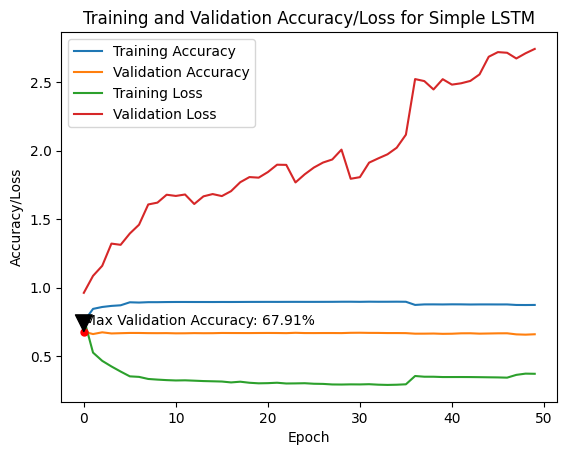

In [47]:
plot_model_loss_accuracy(history_simple_lstm,"Simple LSTM")

In [48]:
# list all gpu devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7478389253706696859
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5618622464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3464514541362225144
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
